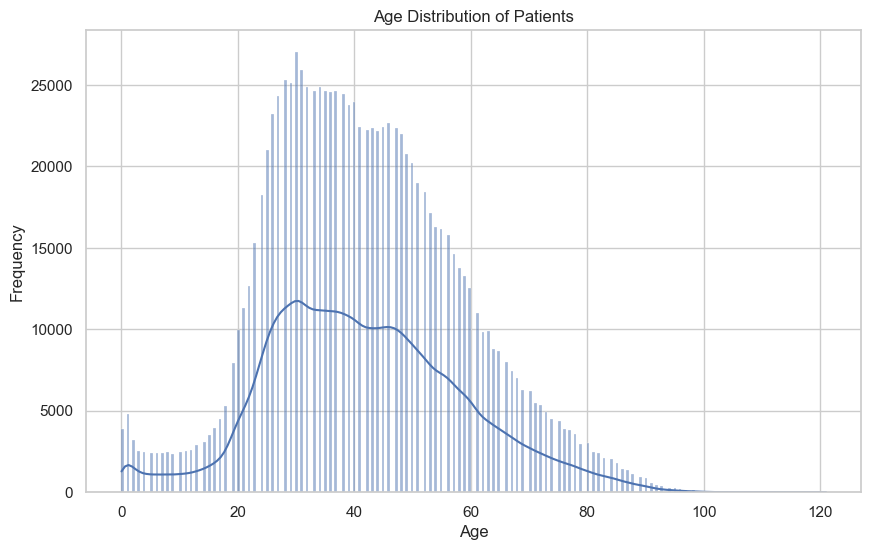

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

covid_data = pd.read_csv('Covid Data.csv')
# Setting up the visualization style
sns.set(style="whitegrid")

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(covid_data['AGE'], kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


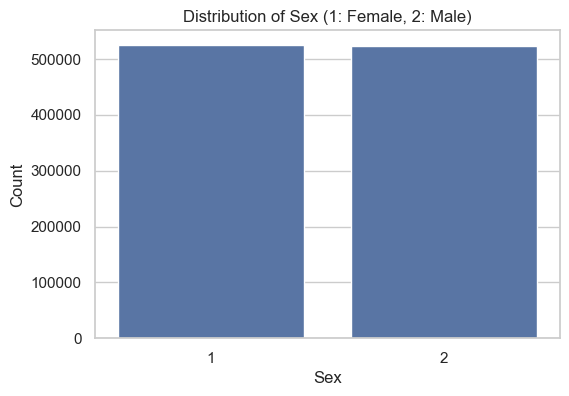

In [36]:
# Distribution of Sex
plt.figure(figsize=(6, 4))
sns.countplot(x='SEX', data=covid_data)
plt.title('Distribution of Sex (1: Female, 2: Male)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


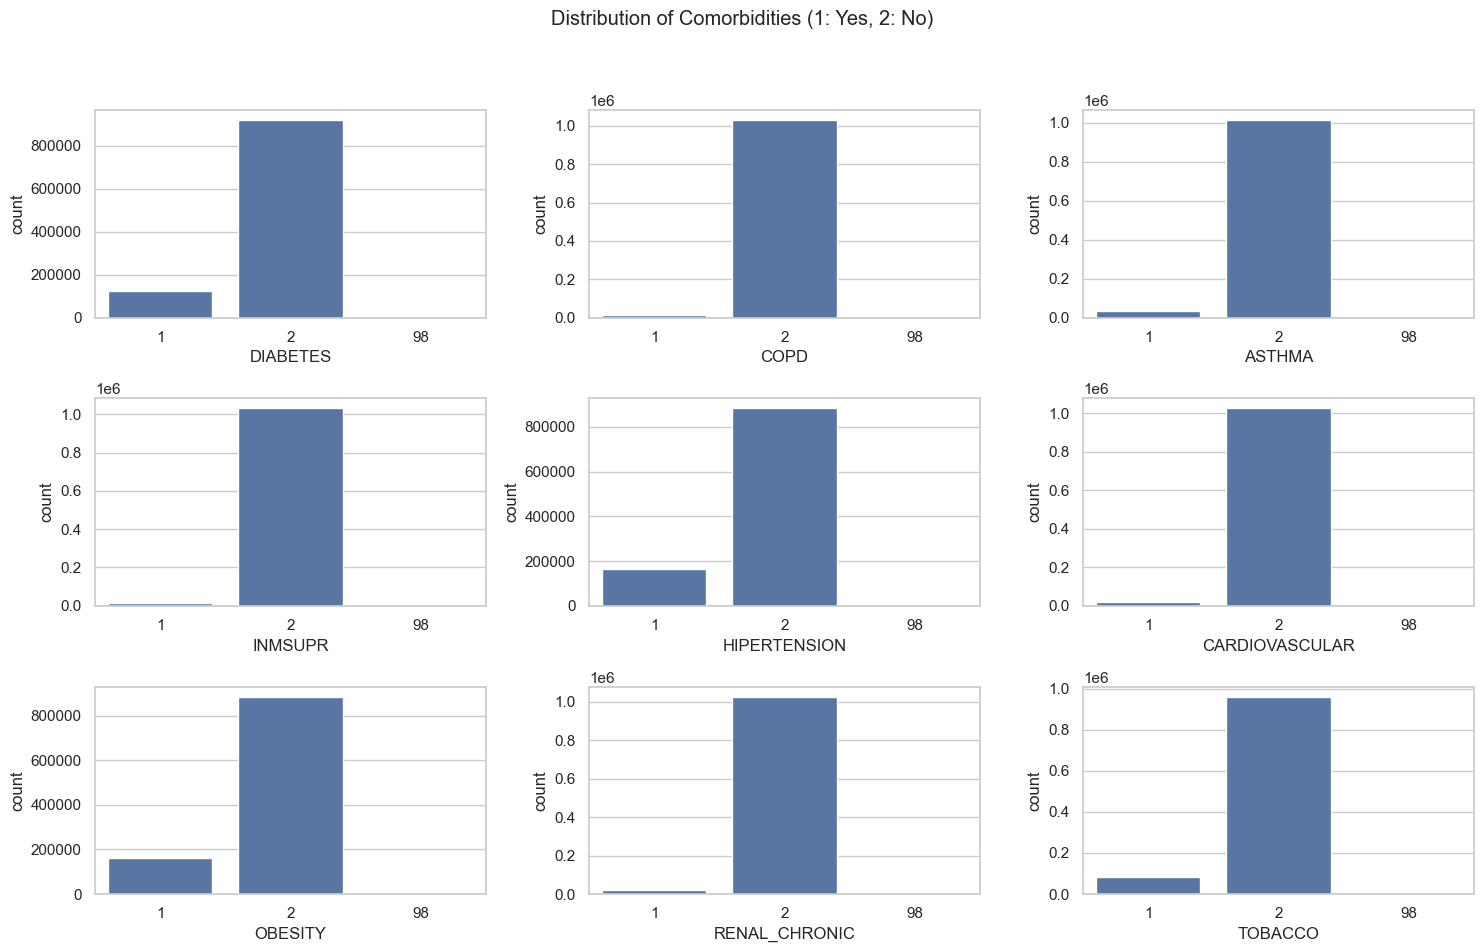

In [37]:
# 3. Distribution of Comorbidities
comorbidities = ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Distribution of Comorbidities (1: Yes, 2: No)')
for i, comorbidity in enumerate(comorbidities):
    sns.countplot(x=comorbidity, data=covid_data, ax=axes[i//3, i%3])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



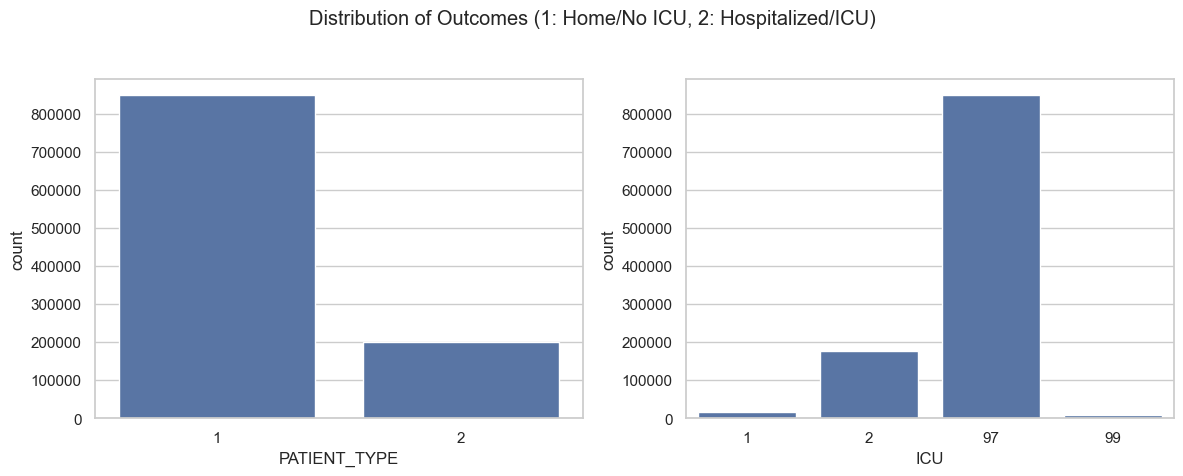

In [38]:
# Outcomes (Hospitalization, ICU admission)
outcomes = ['PATIENT_TYPE', 'ICU']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Distribution of Outcomes (1: Home/No ICU, 2: Hospitalized/ICU)')
for i, outcome in enumerate(outcomes):
    sns.countplot(x=outcome, data=covid_data, ax=axes[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



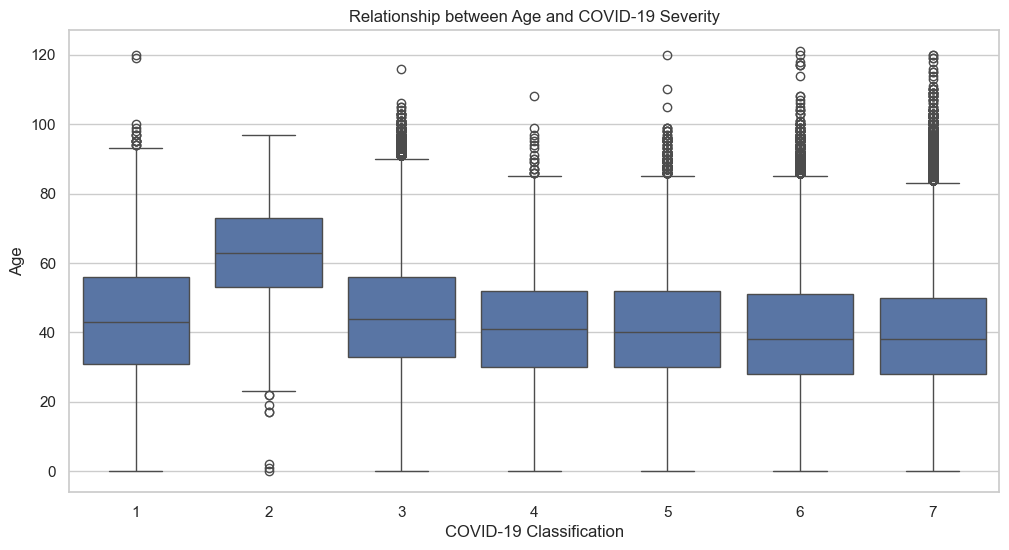

In [39]:
# Relationship between Age and COVID-19 Severity (using 'CLASIFFICATION_FINAL' as a proxy for severity)
plt.figure(figsize=(12, 6))
sns.boxplot(x='CLASIFFICATION_FINAL', y='AGE', data=covid_data)
plt.title('Relationship between Age and COVID-19 Severity')
plt.xlabel('COVID-19 Classification')
plt.ylabel('Age')
plt.show()


In [40]:
# Function to perform chi-squared test
def perform_chi2_test(data, column, outcome):
    contingency_table = pd.crosstab(data[column], data[outcome])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Selecting a few variables for chi-squared tests
variables_for_test = ['SEX', 'DIABETES', 'COPD', 'ASTHMA', 'OBESITY']
outcome_variable = 'PATIENT_TYPE'  # 1 for returned home, 2 for hospitalization

# Performing chi-squared tests
chi2_results = {var: perform_chi2_test(covid_data, var, outcome_variable) for var in variables_for_test}

chi2_results

{'SEX': 0.0,
 'DIABETES': 0.0,
 'COPD': 0.0,
 'ASTHMA': 4.616579289594234e-144,
 'OBESITY': 0.0}

In [41]:
# Preparing data for the logistic regression model
features = ['AGE', 'SEX', 'DIABETES', 'COPD', 'ASTHMA', 'OBESITY']
X = covid_data[features].fillna(0)  # Replacing missing values with 0 for simplicity
y = covid_data['PATIENT_TYPE']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Making predictions and evaluating the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Print the results in a more readable format for Jupyter Notebook
print(f"Model Evaluation:\n")
print(f"Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_report_result)


Model Evaluation:

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.98      0.90    169783
           2       0.62      0.14      0.22     39932

    accuracy                           0.82    209715
   macro avg       0.72      0.56      0.56    209715
weighted avg       0.79      0.82      0.77    209715



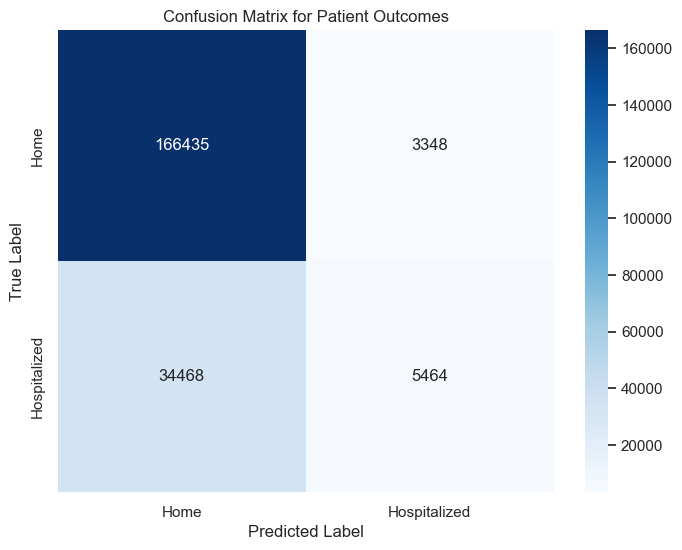

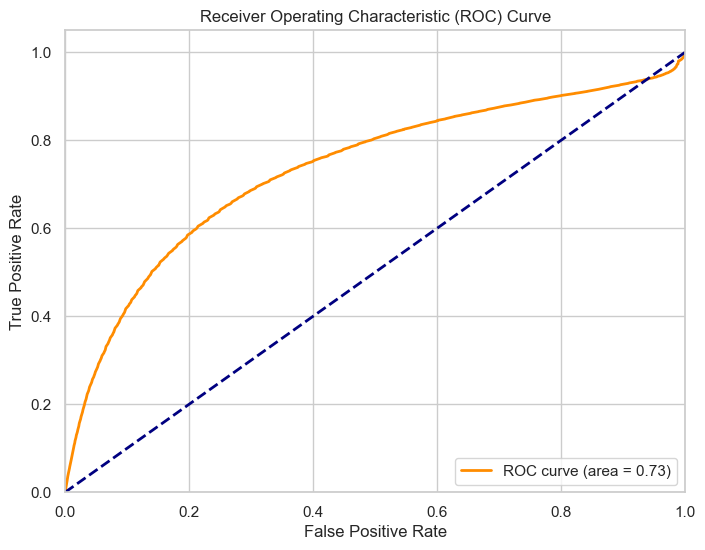

In [42]:
# Generating a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Home', 'Hospitalized'], yticklabels=['Home', 'Hospitalized'])
plt.title('Confusion Matrix for Patient Outcomes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting ROC Curve and calculating AUC
from sklearn.metrics import roc_curve, auc

# Calculating probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
